Imports

In [21]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)

Load Dataset

In [22]:
# Load raw data
df = pd.read_csv("../data/crop1.csv")

# Preview
df.head()


,Area,Item,Element,Year,Unit,Value
0,Afghanistan,"Almonds, with shell",Area harvested,1975,ha,0.0
1,Afghanistan,"Almonds, with shell",Area harvested,1976,ha,5900.0
2,Afghanistan,"Almonds, with shell",Area harvested,1977,ha,6000.0
3,Afghanistan,"Almonds, with shell",Area harvested,1978,ha,6000.0
4,Afghanistan,"Almonds, with shell",Area harvested,1979,ha,6000.0


In [23]:
# Check structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895975 entries, 0 to 1895974
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Area     object 
 1   Item     object 
 2   Element  object 
 3   Year     int64  
 4   Unit     object 
 5   Value    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 86.8+ MB


In [24]:
# Summary statistics
df.describe()

,Year,Value
count,1.895975e+06,1.766475e+06
mean,1.992321e+03,1.077275e+06
std,1.718118e+01,1.403138e+07
min,1.961000e+03,0.000000e+00
25%,1.978000e+03,4.500000e+03
50%,1.994000e+03,2.687500e+04
75%,2.007000e+03,1.303910e+05
max,2.020000e+03,1.955308e+09


Clean Filter: Relevant Elements + Valid Years

In [25]:
# Keep only valid elements
relevant_elements = ['Production', 'Area harvested', 'Yield']
df = df[df['Element'].isin(relevant_elements)]

# Keep years within 1961–2020
df = df[df['Year'].between(1961, 2020)]

# Combine Element + Unit
df["Element_Unit"] = df["Element"] + " (" + df["Unit"] + ")"

df.head()

,Area,Item,Element,Year,Unit,Value,Element_Unit
0,Afghanistan,"Almonds, with shell",Area harvested,1975,ha,0.0,Area harvested (ha)
1,Afghanistan,"Almonds, with shell",Area harvested,1976,ha,5900.0,Area harvested (ha)
2,Afghanistan,"Almonds, with shell",Area harvested,1977,ha,6000.0,Area harvested (ha)
3,Afghanistan,"Almonds, with shell",Area harvested,1978,ha,6000.0,Area harvested (ha)
4,Afghanistan,"Almonds, with shell",Area harvested,1979,ha,6000.0,Area harvested (ha)


Handle Missing Values

In [26]:
# Missing value stats
missing_by_area = df.groupby("Area")["Value"].apply(lambda x: x.isnull().mean()).sort_values(ascending=False)
missing_by_area.head(10)

Area
China, Macao SAR                    0.677419
South Sudan                         0.495726
Palestine                           0.475667
Bahamas                             0.376623
Namibia                             0.301544
Bhutan                              0.285144
Singapore                           0.280827
Belize                              0.276244
Micronesia (Federated States of)    0.275862
Saint Lucia                         0.271454
Name: Value, dtype: float64

In [27]:
# Drop missing Value rows
df = df.dropna(subset=["Value"])

Transform: Winsorization + Log

In [28]:
# Winsorization (capping extremes)
df["Value_winsor"] = winsorize(df["Value"], limits=[0.01, 0.01])

# Log transform (safe)
df["Value_log"] = np.log1p(df["Value_winsor"])  # log(1 + x) handles 0s safely

# Check transformation effect
df[["Value", "Value_winsor", "Value_log"]].describe()

,Value,Value_winsor,Value_log
count,1.766475e+06,1.766475e+06,1.766475e+06
mean,1.077275e+06,5.115054e+05,9.981698e+00
std,1.403138e+07,2.182528e+06,2.809236e+00
min,0.000000e+00,6.000000e+00,1.945910e+00
25%,4.500000e+03,4.500000e+03,8.412055e+00
50%,2.687500e+04,2.687500e+04,1.019899e+01
75%,1.303910e+05,1.303910e+05,1.177830e+01
max,1.955308e+09,1.759109e+07,1.668290e+01


Decade Binning

In [29]:
df["Decade"] = (df["Year"] // 10) * 10
df["Decade"].value_counts().sort_index()

Decade
1960    218529
1970    248287
1980    266477
1990    318976
2000    338273
2010    341472
2020     34461
Name: count, dtype: int64

Summary Groupings

In [30]:
# Top and bottom areas
display(df["Area"].value_counts().head(10))
display(df["Area"].value_counts().tail(10))

# Top and rare items
display(df["Item"].value_counts().head(10))
display(df["Item"].value_counts().tail(10))

Area
World                                      21123
Asia                                       21030
Net Food Importing Developing Countries    20175
Americas                                   20031
Africa                                     19783
Eastern Asia                               19707
Low Income Food Deficit Countries          19705
South America                              18563
Least Developed Countries                  18448
Land Locked Developing Countries           18289
Name: count, dtype: int64

Area
Sudan                               1143
Equatorial Guinea                   1125
Micronesia (Federated States of)     714
Tuvalu                               609
Tokelau                              600
Nauru                                572
South Sudan                          531
China, Macao SAR                     180
Faroe Islands                        180
Marshall Islands                      90
Name: count, dtype: int64

Item
Vegetables, fresh nes           38299
Maize                           33103
Tomatoes                        32207
Potatoes                        30983
Fruit, fresh nes                28904
Tobacco, unmanufactured         27823
Onions, dry                     27294
Cabbages and other brassicas    27154
Bananas                         26554
Rice, paddy                     26424
Name: count, dtype: int64

Item
Melonseed              5389
Pistachios             5250
Vanilla                5152
Persimmons             4848
Kiwi fruit             4653
Cinnamon (cannella)    3893
Cloves                 3358
Tung nuts              3093
Ramie                  2719
Tallowtree seed         654
Name: count, dtype: int64

Pivot for Wide Format (for modeling or visualization)

In [31]:
pivot_df = df.pivot_table(
    index=["Area", "Item", "Year"], 
    columns="Element", 
    values="Value", 
    aggfunc="mean"
).reset_index()

pivot_df.head()

Element,Area,Item,Year,Area harvested,Production,Yield
0,Afghanistan,"Almonds, with shell",1975,0.0,0.0,NaN
1,Afghanistan,"Almonds, with shell",1976,5900.0,9800.0,16610.0
2,Afghanistan,"Almonds, with shell",1977,6000.0,9000.0,15000.0
3,Afghanistan,"Almonds, with shell",1978,6000.0,12000.0,20000.0
4,Afghanistan,"Almonds, with shell",1979,6000.0,10500.0,17500.0


Save Cleaned Data

In [34]:
df.to_csv("../data/processed/crop1_clean.csv", index=False)
pivot_df.to_csv("../data/processed/crop_data_pivot.csv", index=False)

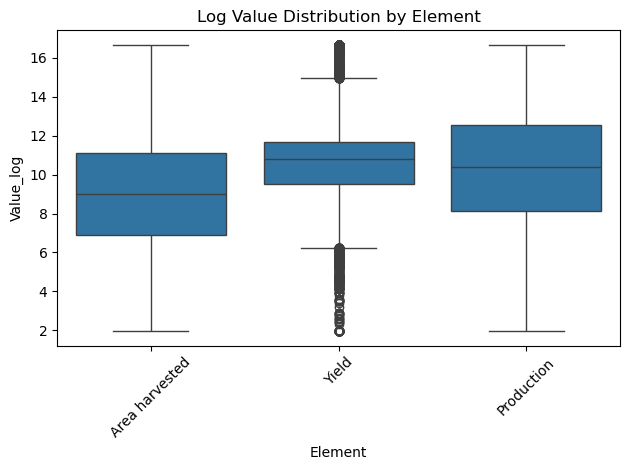

In [35]:
sns.boxplot(data=df, x="Element", y="Value_log")
plt.title("Log Value Distribution by Element")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()